# Building a Convolutional Neural Network from Scratch

[**1. Convolution functions**](#1.-Convolution-functions)
- Zero Padding
- Convolve window
- Convolution forward
- Convolution backward

[**2. Pooling functions**](#2.-Pooling-functions)
- Pooling forward
- Create mask (max pooling - backward pass)
- Distribute value (average pooling - backward pass)
- Pooling backward

### Package imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 1. Convolution functions

###  1.1. Zero-Padding

Adding zeros around the border of all images of the dataset X.

**Inputs** :  
- *X*: python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
- *pad*: integer, amount of padding around each image on vertical and horizontal dimensions

**Outputs** :  
- *X_pad*: padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)

In [2]:
def zero_pad(X, pad):

    X_pad = np.pad(X, ((0,0),(pad,pad),(pad,pad),(0,0)), mode='constant', constant_values = (0,0))
    
    return X_pad

**Testing the function**

x.shape =
 (4, 3, 3, 2)
x_pad.shape =
 (4, 7, 7, 2)


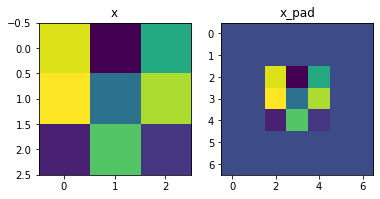

In [3]:
np.random.seed(1)
x = np.random.randn(4, 3, 3, 2)
x_pad = zero_pad(x, 2)
print ("x.shape =\n", x.shape)
print ("x_pad.shape =\n", x_pad.shape)
fig, axarr = plt.subplots(1, 2)
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_pad')
axarr[1].imshow(x_pad[0,:,:,0])

###  1.2. Convolution window

Applying one filter defined by parameters W on a single slice (a_slice_prev) of the output activation of the previous layer.

**Inputs** :  
- *a_slice_prev*: slice of input data of shape (f, f, n_C_prev)
- *W*: weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
- *b*: bias parameters contained in a window - matrix of shape (1, 1, 1)

**Outputs** :  
- *Z*: a scalar value, the result of convolving the sliding window (W, b) on a slice x of the input data

In [4]:
def conv_single_step(a_slice_prev, W, b):

    s = a_slice_prev * W
    Z = np.sum(s)
    Z = Z + float(b)

    return Z

**Testing the function**

In [5]:
np.random.seed(1)
a_slice_prev = np.random.randn(4, 4, 3)
W = np.random.randn(4, 4, 3)
b = np.random.randn(1, 1, 1)
Z = conv_single_step(a_slice_prev, W, b)
print("Z =", Z)

Z = -6.999089450680221


###  1.3. Convolution forward

Implementing the forward propagation for a convolution function.

**Inputs** :  
- *A_prev*: output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
- *W*: weights, numpy array of shape (f, f, n_C_prev, n_C)
- *b*: biases, numpy array of shape (1, 1, 1, n_C)
- *hparameters*: python dictionary containing "stride" and "pad"

**Outputs** :  
- *Z*: conv output, numpy array of shape (m, n_H, n_W, n_C)
- *cache*: cache of values needed for the conv_backward() function

In [6]:
def conv_forward(A_prev, W, b, hparameters):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    
    n_H = int((n_H_prev - f + (2*pad))/stride) + 1
    n_W = int((n_W_prev - f + (2*pad))/stride) + 1
    
    Z = np.zeros((m, n_H, n_W, n_C))

    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        for h in range(n_H):
            vert_start = h*stride
            vert_end = vert_start + f
            for w in range(n_W):
                horiz_start = w*stride
                horiz_end = horiz_start + f
                for c in range(n_C):
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    weights = W[:, :, :, c]
                    biases = b[0, 0, 0, c]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, weights, biases)

    cache = (A_prev, W, b, hparameters)
    
    assert(Z.shape == (m, n_H, n_W, n_C))
    
    return Z, cache

**Testing the function**

In [7]:
np.random.seed(1)
A_prev = np.random.randn(10,5,7,4)
W = np.random.randn(3,3,4,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 1, "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
print("Z's mean =\n", np.mean(Z))
print("Z[3,2,1] =\n", Z[3,2,1])
print("cache_conv[0][1][2][3] =\n", cache_conv[0][1][2][3])

Z's mean =
 0.6923608807576933
Z[3,2,1] =
 [-1.28912231  2.27650251  6.61941931  0.95527176  8.25132576  2.31329639
 13.00689405  2.34576051]
cache_conv[0][1][2][3] =
 [-1.1191154   1.9560789  -0.3264995  -1.34267579]


###  1.4. Convolution Backward

Implementing the backward propagation for a convolution function.

**Inputs** :  
- *dZ*: gradient of the cost with respect to the output of the conv layer (Z), numpy array of shape (m, n_H, n_W, n_C)
- *cache*: cache of values needed for the conv_backward(), output of conv_forward()

**Outputs** :  
- *dA_prev*: gradient of the cost with respect to the input of the conv layer (A_prev), numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
- *dW*: gradient of the cost with respect to the weights of the conv layer (W), numpy array of shape (f, f, n_C_prev, n_C)
- *db*: gradient of the cost with respect to the biases of the conv layer (b), numpy array of shape (1, 1, 1, n_C)

In [8]:
def conv_backward(dZ, cache):

    (A_prev, W, b, hparameters) = cache
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparameters["stride"]
    pad = hparameters["pad"]
    (m, n_H, n_W, n_C) = dZ.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))                           
    dW = np.zeros((f, f, n_C_prev, n_C))
    db = np.zeros((1, 1, 1, n_C))
    A_prev_pad = zero_pad(A_prev, pad)
    dA_prev_pad = zero_pad(dA_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i,:,:,:]
        da_prev_pad = dA_prev_pad[i,:,:,:]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f

                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end, :] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i, h, w, c]
                    db[:,:,:,c] += dZ[i, h, w, c]
                    
        dA_prev[i, :, :, :] = da_prev_pad[pad:-pad, pad:-pad, :]

    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))
    
    return dA_prev, dW, db

**Testing the function**

In [9]:
np.random.seed(1)
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2, "stride": 2}
Z, cache_conv = conv_forward(A_prev, W, b, hparameters)
dA, dW, db = conv_backward(Z, cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 1.4524377775388075
dW_mean = 1.7269914583139097
db_mean = 7.839232564616838


## 2. Pooling functions

###  2.1. Pooling forward

Implementing the forward pass of the pooling layer.

**Inputs** :  
- *A_prev*: output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
- *hparameters*: python dictionary containing "f" and "stride"
- *mode*: the pooling mode we would like to use, defined as a string ("max" or "average")

**Outputs** :  
- *A*: output of the pool layer, numpy array of shape (m, n_H, n_W, n_C)
- *cache*: cache used in the backward pass of the pooling layer, contains the input and hparameters

In [10]:
def pool_forward(A_prev, hparameters, mode = "max"):

    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters["f"]
    stride = hparameters["stride"]

    n_H = int(1 + (n_H_prev - f) / stride)
    n_W = int(1 + (n_W_prev - f) / stride)
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))              

    for i in range(m):
        for h in range(n_H):
            vert_start = h*stride
            vert_end = vert_start + f
            for w in range(n_W):
                horiz_start = w*stride
                horiz_end = horiz_start + f
                for c in range (n_C):
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    if mode == "max":
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mode == "average":
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)

    assert(A.shape == (m, n_H, n_W, n_C))
    
    return A, cache

**Testing the function**

In [11]:
np.random.seed(1)
A_prev = np.random.randn(2, 5, 5, 3)
hparameters = {"stride" : 2, "f": 3}
A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A.shape = " + str(A.shape))
print()
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A.shape = " + str(A.shape))

mode = max
A.shape = (2, 2, 2, 3)

mode = average
A.shape = (2, 2, 2, 3)


###  2.2. Create mask (max pooling - backward pass)

Creating a mask from an input matrix x, to identify the max entry of x.

**Inputs** :  
- *x*: array of shape (f, f)

**Outputs** :  
- *mask*: array of the same shape as window, contains a True at the position corresponding to the max entry of x

In [12]:
def create_mask_from_window(x):

    mask = (x == np.max(x))

    return mask

**Testing the function**

In [13]:
np.random.seed(1)
x = np.random.randn(2,3)
mask = create_mask_from_window(x)
print('x = ', x)
print("mask = ", mask)

x =  [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask =  [[ True False False]
 [False False False]]


###  2.3. Distribute value (average pooling - backward pass)

Distributing the input value in the matrix of dimension shape.

**Inputs** :  
- *dz*: input scalar
- *shape*: the shape (n_H, n_W) of the output matrix for which we want to distribute the value of dz

**Outputs** :  
- *a*: array of size (n_H, n_W) for which we distributed the value of dz

In [14]:
def distribute_value(dz, shape):

    (n_H, n_W) = shape
    
    average = dz / (n_H * n_W)
    a = np.ones((n_H, n_W)) * average
    
    return a

**Testing the function**

In [15]:
a = distribute_value(2, (2,2))
print('distributed value =', a)

distributed value = [[0.5 0.5]
 [0.5 0.5]]


###  2.4. Pooling backward

Implementing the backward pass of the pooling layer.

**Inputs** :  
- *dA*: gradient of cost with respect to the output of the pooling layer, same shape as A
- *cache*: cache output from the forward pass of the pooling layer, contains the layer's input and hparameters
- *mode*: the pooling mode we would like to use, defined as a string ("max" or "average")

**Outputs** :  
- *dA_prev*: gradient of cost with respect to the input of the pooling layer, same shape as A_prev

In [16]:
def pool_backward(dA, cache, mode = "max"):

    (A_prev, hparameters) = cache
    stride = hparameters["stride"]
    f = hparameters["f"]
    m, n_H_prev, n_W_prev, n_C_prev = A_prev.shape
    m, n_H, n_W, n_C = dA.shape
    
    dA_prev = np.zeros((m, n_H_prev, n_W_prev, n_C_prev))
    
    for i in range(m):
        a_prev = A_prev[i,:,:,:]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h*stride
                    vert_end = vert_start + f
                    horiz_start = w*stride
                    horiz_end = horiz_start + f
                    if mode == "max":
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        mask = create_mask_from_window(a_prev_slice)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += (mask * dA[i, h, w, c])
                    elif mode == "average":
                        da = dA[i, h, w, c]
                        shape = (f,f)
                        dA_prev[i, vert_start: vert_end, horiz_start: horiz_end, c] += distribute_value(da, shape)

    assert(dA_prev.shape == A_prev.shape)
    
    return dA_prev

**Testing the function**

In [17]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)
dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]
